## Part 4: Linear combination fitting

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

The following notebook explains the following:

1. Perform linear combination fitting (LCF) of spectra.

**Important:** This tutorial assumes you have succesfully completed the previous tutorials in the series:

- [Part 1: Basics of data processing](01.basics_data_processing.ipynb)
- [Part 2: Normalization and background removal](02.background_removal.ipynb)
- [Part 3: Creating custom report and figures](03.custom_report_figure.ipynb)


In [1]:
# checking version of araucaria and dependencies
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.8


### 1. Accesing the database

In this case we will be reading and processing a minerals database measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. Fe_database.h5

We first retrieve the filepath to the database and summarize its contents.

<div class="alert alert-info">
    
    **Note**
    
    If you prefer to process your own database, just modify the filepath to point to the location of your file.
</div>

In [2]:
# retrieving filepath
from pathlib import Path
from araucaria.testdata import get_testpath
from araucaria.io import summary_hdf5

fpath = get_testpath('Fe_database.h5')

# summarizing database
report = summary_hdf5(fpath)
report.show()

id  dataset                 mode    n   
1   FeIISO4_20K             mu      5   
2   Fe_Foil                 mu_ref  5   
3   Ferrihydrite_20K        mu      5   
4   Goethite_20K            mu      5   
5   Goethite_20K_10spectra  mu      10  


### 2. Creating a group to fit

We will be creating an example signal to fit, considering a mixture of the 2 original signals from ferrihydrite and goethite minerals.
The mixture will be created through the [merge()](../xas/xas_merge.rst#araucaria.xas.merge.merge) function. Note that the original signals are multiplied by amplitude factors, in order to prevent proportions larger than 1 during the fit.

Finally we store the signals in a [Collection](../main/main_collection.rst#araucaria.main.collection.Collection) and produce a summary report.

In [3]:
from araucaria.io import read_hdf5
from araucaria.xas import merge
from araucaria import Collection

# name of groups
groupnames = ('Ferrihydrite_20K', 'Goethite_20K')
amp        = [0.5, 0.5]

# initializing collections
collection = Collection()
auxiliary  = Collection()

for i,name in enumerate(groupnames):
    group = read_hdf5(fpath, name)
    collection.add_group(group, tag='ref')
    
    group.mu = amp[i]*group.mu
    auxiliary.add_group(group)

report, merge = merge(auxiliary, name='sample')
collection.add_group(merge, tag='scan')

report = collection.summary(optional=['edge_step'])
report.show()

id  dataset           tag   mode  n  edge_step  
1   Ferrihydrite_20K  ref   mu    5  0.28779    
2   Goethite_20K      ref   mu    5  0.4169     
3   sample            scan  mu    2  0.35121    


### 3. Computing expected amplitudes from the LCF

As seen from the summary report, the edge steps of the original signals are not equal. Therefore, a mixture with equal proportions of each signal will distribute with respect to the edge step values. We can compute the expected proportions by normalizing the percentages with respect to the sum of edge step values:

In [4]:
from numpy import sum

edge_steps = report.get_cols(names=['edge_step'])[:2]
edge_steps = [amp[i]*float(val) for i, val in enumerate(edge_steps)]
amplitudes = edge_steps/sum(edge_steps)

for i, val in enumerate(amplitudes):
    print('{0:16}: {1:1.3f}'.format(groupnames[i], val))

Ferrihydrite_20K: 0.408
Goethite_20K    : 0.592


### 4. Performing XANES LCF

Now we can perform the linear combination fitting analysis with the [lcf()](../fit/fit_lcf.rst#araucaria.fit.lcfit.lcf) function. Once the fit is finished we can print a summary with the [lcf_report()](../fit/fit_lcf.rst#araucaria.fit.lcfit.lcf_report) function.

In [5]:
from araucaria.fit import lcf, lcf_report

# parameters for normalization
k_edge = 7112
pre_edge_kws = {'pre_range' :[-160, -40],
                'post_range': [140, 950], 
                'nvict'     :0, 
                'e0'        :k_edge}

lcf_kws      = {'fit_region': 'xanes',
                'sum_one'   : False,
                'fit_range'  : [k_edge-20,k_edge+70]}

out = lcf(collection, pre_edge_kws=pre_edge_kws, **lcf_kws)
print(lcf_report(out))

[[Parameters]]
    fit_region         = xanes
    fit_range          = [7092, 7182]
    sum_one            = False
    pre_edge_kws       = {'pre_range': [-160, -40], 'post_range': [140, 950], 'nvict': 0, 'e0': 7112, 'update': True}
[[Groups]]
    scan               = sample
    ref1               = Ferrihydrite_20K
    ref2               = Goethite_20K
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 168
    # variables        = 2
    chi-square         = 1.5177e-07
    reduced chi-square = 9.1428e-10
    Akaike info crit   = -3494.57580
    Bayesian info crit = -3488.32787
[[Variables]]
    amp1:  0.40894498 +/- 9.9474e-05 (0.02%) (init = 0.5)
    amp2:  0.59225273 +/- 9.9337e-05 (0.02%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, amp2) = -1.000


As seen in the fit report, our prediction for the amplitudes was accurate.
We can visually compare the fitted curve with the original signal with the [fig_lcf()](../plot_module.rst#araucaria.plot.fig_lcf.fig_lcf) function.
As usual, the function accepts a dictionary to set the parameters for the XAFS figures (`fig_pars`) as well as a dictionary to set general figure parameters (`fig_kws`). ) function

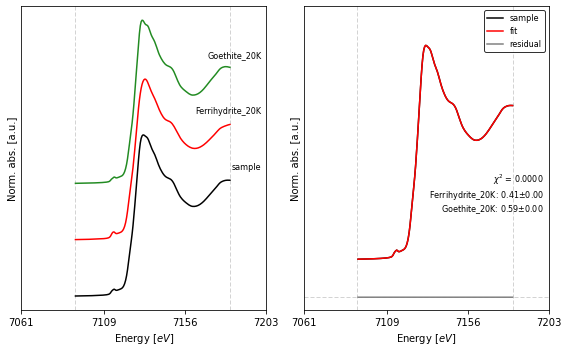

In [6]:
import matplotlib.pyplot as plt
from araucaria.plot import fig_lcf

# figure parameters
offset   = 0.5
fig_kws  = {'figsize'   : (8, 5)}  # size figure
fig_pars = {'e_range'  : (k_edge-50, k_edge+90),
           'e_ticks'   : [k_edge-51, k_edge-3, k_edge+44, k_edge+91],
           'prop_cycle': [{'color'     : ['black', 'red', 'forestgreen'],
                           'linewidth' : [1.5    , 1.5  , 1.5          ],},
                          {'color'     : ['black', 'red', 'grey'],
                           'linewidth' : [1.5    , 1.5  , 1.5   ],}
                         ]}

fig, ax = fig_lcf(out, fig_pars=fig_pars, **fig_kws)
fig.tight_layout()
plt.show()